# Vehicle Detection & Tracking Using Computer Vision And Machine Learning

When we drive, we constantly pay attention to our environment, as our safety and that of many other people are at stake. We particularly look out for position of potential _obstacles_, whether they be other cars, pedestrians, or object on the road. Similarly, as we develop the intelligence and sensors necessary to power an autonomous vehicle, it is of the utmost importance that such a vehicle can detect obstacles as well, as it reinforces the car's understanding of its environment. One of the most important types of ostacles to detect is other vehicles on the road, as they would most likely be the in our lane or neighbouring ones and therefore constitute a potential hazard.

A number of techniques for obstacle detection have been developed throughout the literature, from traditional computer vision techniques to deep learning ones, and more. In this exercise, we build a vehicle detector by employing a conventional computer vision technique called _Histogram of Oriented Gradients (HOG)_, combined with a machine learning algorithm called _Support Vector Machines (SVM)_.

In [1]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from importlib import reload
import utils; reload(utils)
from utils import *

In [3]:
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

project_dataset_dir = "project_dataset"
project_dataset_vehicles_dir = "project_dataset/vehicles"
project_dataset_non_vehicles_dir = "project_dataset/non-vehicles"

In [466]:
import pickle

def save_as_pickle(data, pickle_file_name):
    """
    Saves the data inside a pickle file
    """
    pickle.dump( data, open( pickle_file_name, "wb" ) )
    
def load_as_pickle(pickle_file_name):
    """
    Returns the loaded data inside the specified pickle file
    """
    return pickle.load( open( pickle_file_name, "rb" ) )

# Dataset exploration

Udacity generously provided a _balanced_ dataset with the following characteristics:
* ~ 9K images of vehicles
* ~ 9K images of non-vehicles
* all images are 64x64
The dataset comes from the [GTI Vehicle Image Database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), [KITTI Vision Benchmark Suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself. The latter is much larger and was not used for this project. However, it would be a great addition in the future, especially as we plan to build a classifier using deep learning.

In [4]:
# Let's fetch the paths of training images
project_vehicle_img_paths = glob.glob(project_dataset_vehicles_dir + "/**/*.png", recursive=True)
len(project_vehicle_img_paths)

8792

In [5]:
project_non_vehicle_img_paths = glob.glob(project_dataset_non_vehicles_dir + "/**/*.png", recursive=True)
len(project_non_vehicle_img_paths)

8968

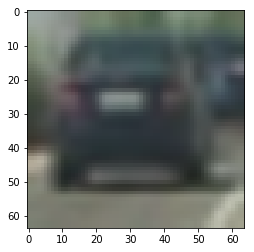

In [6]:
example_img = load_image(project_vehicle_img_paths[0])
plt.imshow(example_img)

In [7]:
class Dataset:
    """
    Represents top level information about a given dataset
    """
    def __init__(self, data_paths, labels, image_size, image_type="png"):
        self.data_paths = data_path
        self.labels = labels
        self.image_size = image_size
        self.image_type = image_type
    
    def load_data(self):
        """
        Identifies all files in the dataset and loads the images
        """
        if len(self.labels) != len(self.data_paths):
            print("Mismatch in length")
            # TODO to continue

# Feature Extraction

In this section, we apply Histogram of Oriented Gradients and Color bins to our input image to create our features, which will then be fed to a classifier. But before we employ these techniques, we must first define a function to subsample our input.

In [8]:
def subsample_image(img, new_size=(32,32), single_vector=True):
    """
    Resizes the image to the new size and returns either a 1-D vector or multi-dimensional matrix depending
    on the value of single_vector
    """
    features = cv2.resize(img, new_size)
    return features.ravel() if single_vector else features

In [461]:
def change_color_space(img, cspace="RGB"):
    """
    Takes in a RGB image and returns a new image in the target color space.
    If the current image and target image are both rgb, then a new copy of the image is returned
    """
    feature_image = None
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == "YCrCb":
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img) 
    
    return feature_image

In [418]:
def color_histogram(img, nbins=32, bins_range=(0, 256)):
    """
    Returns the histograms of the color image across all channels, as a concatenanted feature vector
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [419]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler


In [510]:
def pick_features(feat_sub_sample, feat_color_hist, feat_hog, 
                  use_sub_sample=False, use_color_hist=False, use_hog=True):
    """
    Returns a feature vector where the different individual features were retained (or not)
    """
    feature_vec = []
    if use_sub_sample:
        feature_vec = feat_sub_sample
    if use_color_hist:
        feature_vec = feat_color_hist if len(feature_vec) == 0 else np.hstack((feature_vec, feat_color_hist))
    if use_hog:
        feature_vec = feat_hog if len(feature_vec) == 0 else np.hstack((feature_vec, feat_hog))
    
    return feature_vec

In [514]:
def compute_features(img, color_space="YCrCb", subsample_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                    hog_orient=9, hog_pix_per_cell=8, hog_cells_per_block=2, hog_block_norm="L2-Hys",
                    hog_color_channels=[0, 1, 2], hog_grayscale=False):
    """
    Computes the features of the given image, by using a combination of:
    - image subsampling
    - color histogram
    - histogram of gradients
    The vector contains all concatenated (and unscaled) features computed
    """
    img_cspace = change_color_space(img, cspace=color_space)
    img_sub_sample = subsample_image(img_cspace, new_size=subsample_size)
    img_color_hist = color_histogram(img_cspace, nbins=hist_bins, bins_range=hist_range)

    hog_features = []
    if hog_color_channels == None:            
        hog_features, img_hog = hog(to_grayscale(img), 
                      pixels_per_cell=(hog_pix_per_cell, hog_pix_per_cell), 
                     cells_per_block=(hog_cells_per_block, hog_cells_per_block),
                     block_norm=hog_block_norm, visualise=True, feature_vector=True)
    else:
        for ch in hog_color_channels:
            hf, img_hog = hog(img_cspace[:,:,ch], 
                      pixels_per_cell=(hog_pix_per_cell, hog_pix_per_cell), 
                     cells_per_block=(hog_cells_per_block, hog_cells_per_block),
                     block_norm=hog_block_norm, visualise=True, feature_vector=True)
            hog_features = hf if len(hog_features) == 0 else np.concatenate((hog_features, hf))
        
    return pick_features(img_sub_sample, img_color_hist, hog_features)

In [515]:
def normalise_features(features, normaliser=None):
    """
    Returnes the tuple (normalised_features, normaliser), 
    where normaliser can normalise future data by applying the function normaliser.transform(data).
    The function can accept a default normaliser. If none is provided, one will be created and returned
    """
    stacked_features = np.vstack(features).astype(np.float64)
    if normaliser == None:        
        normaliser = StandardScaler().fit(stacked_features)
    normed_features = normaliser.transform(stacked_features)
    
    return normed_features, normaliser

# Classification

In [516]:
# Define pipeline read images with label
# Must return the tuple features, labels where we have as many labels as features

# Then normalise all the features together

def extract_dataset_features(classes_imgs, labels, color_space="YCrCb"):
    all_features = []
    all_labels = []
    for i, class_imgs in enumerate(classes_imgs):
        class_features = []
        class_labels = np.repeat(labels[i], len(class_imgs))
        all_labels = class_labels if len(all_labels) == 0 else np.concatenate((all_labels, class_labels))
        for class_img_path in class_imgs:
            img = load_image(class_img_path)
            img_features = compute_features(img, color_space=color_space)
            class_features.append(img_features)

        all_features.append(class_features)
    
    normed_features, normaliser = normalise_features(all_features)
    
#     y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    return normed_features, all_labels, normaliser    
            


In [ ]:
data_features, data_labels, normaliser = extract_dataset_features([project_vehicle_img_paths, project_non_vehicle_img_paths], ["vehicle", "non_vehicle"])

In [467]:
save_as_pickle(data_features, "features_HOG_YCrCb.p")

In [468]:
save_as_pickle(data_labels, "data_labels.p")
save_as_pickle(normaliser, "normaliser.p")

In [465]:
len(data_features)

17760

In [426]:
len(data_labels)

17760

In [254]:
data_features.shape

(17760, 5388)

In [427]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [428]:
def split_dataset(data, labels, test_pct=0.2):
    """
    Splits the dataset into with training having a proportion of 1 - test_pct, and the test set with propotion test_pct 
    Returns the tuple (X_train, y_train), (X_test, y_test)
    """
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_pct)
    return (X_train, y_train), (X_test, y_test)

In [475]:
def train_classifier(data, labels, method="SVM"):
    """
    Train a classifier on the data and labels and returns the trained classifier
    The classifier itself can be chosen from a variety of options. The default is SVM    
    """
    cfier = None
    if method == "SVM":
        svc = LinearSVC(C=10)
        svc.fit(data, labels)
        cfier = svc
    
    return cfier
    

In [470]:
training_dataset, test_dataset = split_dataset(data_features, data_labels)

In [471]:
training_dataset[0].shape

(14208, 8460)

In [476]:
classifier = train_classifier(training_dataset[0], training_dataset[1])

In [477]:
preds = classifier.predict(test_dataset[0])

In [478]:
accuracy_score(test_dataset[1], preds)

0.97944819819819817

# Pipeline

## Sliding Windows

In [435]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Returns a new image the bounding boxes have been overlaid in the chosen color
    """
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [436]:
def sliding_windows(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Computes the all possible sliding windows for the given image and window parameters
    Returns the positions of the computed sliding windows
    """
    width, height = img.shape[1], img.shape[0]
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = width
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = height
    
    # How many windows would we have if we only took into account window size
    
    
    # What is the actual overlap in total number of pixels
    x_overlap = np.int(xy_window[0] * (1 - xy_overlap[0]))
    y_overlap = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    section_width = x_start_stop[1] - x_start_stop[0]
    section_height = y_start_stop[1] - y_start_stop[0]
    #print("s_width=", section_width, " x_overlap=", x_overlap)
# Using the formula from convolutions (cf. cs231n)
# = W - Conv  (+2P) / Stride + 1 -> Since padding is 0, 2P = 0
    x_total_windows = np.int(((section_width - xy_window[0])  / x_overlap) + 1)
    #print("x_total_windows: ", x_total_windows)
    y_total_windows = np.int(((section_height - xy_window[1])  / y_overlap) + 1)
    #print("y_total_windows: ", y_total_windows)
    
    found_windows = []
    for y in range(0, y_total_windows):
        y_offset = y * y_overlap + y_start_stop[0]
        for x in range(0, x_total_windows):
            x_offset = x * x_overlap + + x_start_stop[0]
            
            top_left = (x_offset, y_offset)
            bottom_right = (x_offset + xy_window[0], y_offset + xy_window[1])
            
            found_windows.append((top_left, bottom_right))
                
    
    return found_windows

In [437]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg", recursive=True)

In [438]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))

In [439]:
test_imgs[0].shape

(720, 1280, 3)

In [440]:
# Strive to maintain the aspect ratio
s_windows = sliding_windows(test_imgs[0], x_start_stop=[720, None], y_start_stop=[350, None], xy_window=(64, 32))

In [441]:
test_img_boxes = draw_boxes(test_imgs[0], s_windows)

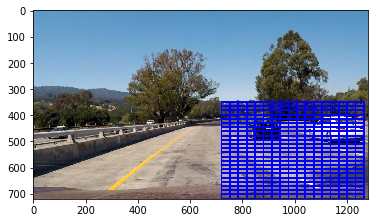

In [442]:
plt.imshow(test_img_boxes)

## Running Classifier On Windows

In [443]:
def find_hot_windows(img, sl_windows, normaliser, classifier, correct_prediction):
    """
    Identifies windows where our classifier "fired" a positive prediction    
    """
    hot_windows = []
    features = []
    for sl_window in sl_windows:
        top_left = sl_window[0]
        bottom_right = sl_window[1]
        img_window = img[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0],:]
        img_window_resized = subsample_image(img_window, new_size=(64, 64), single_vector=False)
        img_window_features = compute_features(img_window_resized)
#        img_window_features_normalised = normaliser.transform(img_window_features)
        features.append(img_window_features)
#         prediction = classifier.predict(img_window_features_normalised.reshape(-1, 1))
#         print(prediction)
#         if prediction == correct_prediction:
#             hot_windows.append(sl_window)
        
    features_normalised, _ = normalise_features(features, normaliser=normaliser)
    predictions = classifier.predict(features_normalised)
    
    for (sl_window, pred) in zip(sl_windows, predictions):
        if pred == correct_prediction:
             hot_windows.append(sl_window)
    
    return hot_windows

In [447]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec, block_norm="L2-Hys")
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec, block_norm="L2-Hys")
        return features

In [448]:
def multi_scale_pipeline(img, x_start, x_stop, y_start, y_stop, scale, cfier, normaliser, 
                         orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                         window=64, color_space="YCrCb", correct_label="vehicle"):
    draw_img = np.copy(img)
    # Normalise our input image
    img = change_color_space(img, cspace=color_space).astype(np.float32)
        
    # Define the image portion we are interested in
    img_tosearch = img[y_start:y_stop, x_start:x_stop, :]
    ctrans_tosearch = img_tosearch
    
    # Subsample this search section if needed
    if scale != 1:
        imshape = ctrans_tosearch.shape 
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define the total number of cells in a given direction (x, y) 
    # This is equivalent to the number of convolutions per axis in deep learning (c.f. cs231n)
    # nxblock = [(axis_size - block_size) / stride] + 1 
    #  -> [(axis_size - pix_per_cell * cells_per_block) / pix_per_cell] + 1
    #  -> [(axis_size / pix_per_cell) - cells_per_block] + 1
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    # Each cell within a block is normalised and produces a histogram of orient features
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    # TODO - make this a parameter    
    # Same here - we use the convolution formula to figure out the number of blocks in the window
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    # Instead of overlap, define how many cells to step
    # TODO - make this a parameter
    # TODO add a '+1' to nxsteps and nysteps formulas
    cells_per_step = 2  
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bounding_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            #print("ypos=", ypos)
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
          
            # Get color features
            spatial_features = subsample_image(subimg, new_size=spatial_size)
            hist_features = color_histogram(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            #test_features = normaliser.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_features = normaliser.transform(pick_features(spatial_features, hist_features, hog_features))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = cfier.predict(test_features)
            
            if test_prediction == correct_label:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bounding_boxes.append([(xbox_left + x_start, ytop_draw+y_start), (xbox_left+win_draw + x_start,ytop_draw+win_draw+y_start)])
                cv2.rectangle(draw_img,(xbox_left + x_start, ytop_draw+y_start), (xbox_left+win_draw + x_start,ytop_draw+win_draw+y_start),(0,0,255),6) 
     
    return bounding_boxes
    #return draw_img

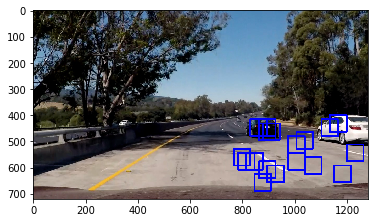

In [500]:
mc_bboxes = multi_scale_pipeline(test_imgs[4], 750, 1280, 400, 700, 1, classifier, normaliser, 9, 8, 2, (32, 32), 32, color_space="YCrCb", window=64)
#print(mc_bboxes)
new_img_boxes = draw_boxes(test_imgs[4], mc_bboxes)
plt.imshow(new_img_boxes)

In [501]:
h_wins = find_hot_windows(test_imgs[0], s_windows, normaliser, classifier, "vehicle")

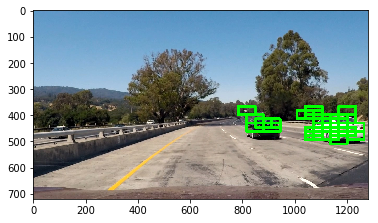

In [502]:
img_hot_windows = draw_boxes(test_imgs[0], h_wins, color=(0, 255, 0), thick=10)
plt.imshow(img_hot_windows)

## Heatmap Thresholding

In [61]:
from scipy.ndimage.measurements import label

In [452]:
def create_heatmap(img, bbox_list):
    """
    Returns a new heatmap where the regions of the image captured by the bounding boxes are "heated-up"
    """
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    heatmap = np.clip(heatmap, 0, 255)

    return heatmap

In [453]:
def threshold_heatmap(heatmap, threshold=2):
    """
    Updates the heatmap by only retaining hot sections whose values are strictly above the threshold.
    All other values are "cooled" down
    """
    heatmap_copy = np.copy(heatmap)
    # Zero out pixels below the threshold
    heatmap_copy[heatmap_copy < threshold] = 0
    # Return thresholded map
    return heatmap_copy

In [454]:
def label_heatmap(heatmap):
    """
    Returns a slice with labels over the original heatmap, as well as the total count of labels found
    """
    return label(heatmap)

In [288]:
def find_smoothed_boxes(img, labels, duplicate=True):
    """
    Returns a set of bounding boxes where each bounding box is the aggregations of neibhouring boxes for the same label
    """
    aggregate_bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        aggregate_bboxes.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
    # Return the image
    
    return aggregate_bboxes

In [455]:
def draw_smoothed_boxes(img, labels, duplicate=True):
    """
    Returns an image where bounding boxes have been drawn around the areas labeled.
    """
    
    copy = np.copy(img) if duplicate else img
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(copy, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return copy

In [456]:
def smoothen_bounding_boxes(img, bboxes, thres=2):
    
    heat = create_heatmap(img, bboxes)
    heat_thresholded = threshold_heatmap(heat, threshold=thres)
    heat_labels = label_heatmap(heat_thresholded)
    smoothed_bboxes = find_smoothed_boxes(img, heat_labels)
    
    return heat, heat_thresholded, heat_labels, smoothed_bboxes

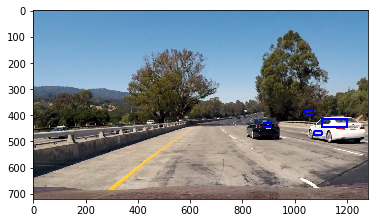

In [499]:
heatmap, heatmap_thres, heatmap_lbs, smoothed_bboxes = smoothen_bounding_boxes(test_imgs[0], h_wins, thres=3)
plt.imshow(draw_boxes(test_imgs[0], smoothed_bboxes))


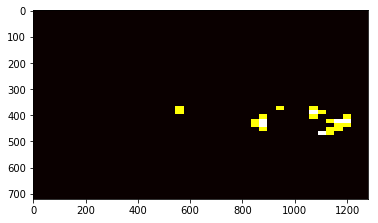

In [47]:
plt.imshow(heatmap, cmap="hot")

# Putting It All Together

In [157]:
def draw_boxes_np(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Returns a new image the bounding boxes have been overlaid in the chosen color
    """
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [201]:
def combine_images(img, overlay_imgs, small_img_size, x_offset, y_offset):
    """
    Returns an image that combines the original image with a set of overlaid images
    The overlaid images are resized to the supplied dimensions and overlaid onto the original image.
    Note that the returned image is a modification of the original image.
    """
    
    for i, overlay_img in enumerate(overlay_imgs):        
        sc = i + 1
        small_overlay_img = cv2.resize(overlay_img, small_img_size)
        overlay_color = small_overlay_img
        if len(overlay_color.shape) < 3:
            overlay_zero = np.zeros_like(small_overlay_img).astype(np.uint8)
            overlay_color = np.dstack((small_overlay_img, overlay_zero, overlay_zero))
        new_y_offset = y_offset
        new_x_offset = sc * x_offset + i * small_img_size[0]
        img[new_y_offset: new_y_offset + small_img_size[1], new_x_offset: new_x_offset + small_img_size[0]] = overlay_color
    
    return img
        

In [402]:
import math
class DetectedObject:
    """
    The DetectedObject class encapsulates information about an object identified by our detector
    """
    def __init__(self, bounding_box, img_patch, frame_nb):
        self.bounding_box = bounding_box
        self.img_patch = img_patch 
        self.frame_nb = frame_nb
        self.centroid = (int((bounding_box[0][0] + bounding_box[1][0]) / 2), int((bounding_box[0][1] + bounding_box[1][1]) / 2))
        
        #plt.imshow(img_patch)
        #plt.show()
    
    def same_object(self, detected_object):
        """
        Returns whether the current detected object is the same as the newly detected one passed as argument
        """
        # First check the distance between the centroids
        dist = math.hypot(detected_object.centroid[0] - self.centroid[0], detected_object.centroid[1] - self.centroid[1])
        print("Distance=", dist)
        if dist <= 10.0:
            return True
        
        # Try to match the patches
        return False
    
    def smoothe_bounding_box(self, same_object):
        """
        Smoothes the bounding boxes between the current object and the same one from another frame
        """
        print("old centroid=", self.centroid)
        self.centroid = (int((same_object.centroid[0] + self.centroid[0]) / 2), int((same_object.centroid[1] + self.centroid[1]) / 2))
        print("new centroid=", self.centroid)
        
        print("old bbox=", self.bounding_box)
        self.bounding_box = ((self.bounding_box + same_object.bounding_box) / 2).astype(np.int32)
        print("new bbox=", self.bounding_box)

In [504]:
class VehicleDetectorWithMemory:
    """
    The VehicleDetectorWithMemory is a class that is capable drawing bounding boxes around vehicles in a video
    """
    def __init__(self, classifier, normaliser, color_space="RGB", frame_sampling_rate=5):
        self.classifier = classifier
        self.normaliser = normaliser
        self.color_space = color_space 
        
        self.current_frame_nb = 0
        self.frame_sampling_rate = frame_sampling_rate
        self.previous_detected_objects = []
        
        # Add extra parameters such as [(ystart, ystop), (x_start, x_stop), scale] 
        # Maybe create a config object that has those and also classifier config?
        
    def process_image(self, img):
        """
        Returns a new image where the vehicles detected on the original image have been highlighted via a bounding box
        """

        bboxes_sc1 = np.asarray(multi_scale_pipeline(img, 750, 1280, 350, 500, 1, self.classifier, self.normaliser, 9, 8, 2, (32, 32), 32, color_space=self.color_space, window=64))
        bboxes_sc2 = np.asarray(multi_scale_pipeline(img, 750, 1280, 420, 600, 1.1, self.classifier, self.normaliser, 9, 8, 2, (32, 32), 32, color_space=self.color_space, window=64))
        bboxes_sc3 = np.asarray(multi_scale_pipeline(img, 750, 1280, 450, 700, 1.3, self.classifier, self.normaliser, 9, 8, 2, (32, 32), 32, color_space=self.color_space, window=64))
        bboxes_sc4 = np.asarray(multi_scale_pipeline(img, 750, 1280, 500, 700, 1.6, self.classifier, self.normaliser, 9, 8, 2, (32, 32), 32, color_space=self.color_space, window=64))
        bboxes_sc5 = np.asarray(multi_scale_pipeline(img, 750, 1280, 500, 700, 2, self.classifier, self.normaliser, 9, 8, 2, (32, 32), 32, color_space=self.color_space, window=64))
        
        combined_boxes = []
        for i, bboxes in enumerate([bboxes_sc1, bboxes_sc2, bboxes_sc3, bboxes_sc4, bboxes_sc5]):
            if len(bboxes) == 0:
                continue
            combined_boxes = bboxes if len(combined_boxes) == 0 else np.concatenate((combined_boxes, bboxes), axis=0)
            
        all_bboxes_drawn = draw_boxes_np(img, combined_boxes)
        heatmap, heatmap_thres, heatmap_lbs, smoothed_bboxes = smoothen_bounding_boxes(img, combined_boxes, thres=3)

        print("Found {0} bounding boxes, {1} smooted ones and {2} labels".format(len(combined_boxes), len(smoothed_bboxes), heatmap_lbs[1]))
        # TODO Convert heatmap to RGB (right now it is single channel)
        
        new_detected_objects = []
        for smoothed_bbox in smoothed_bboxes:
            # create a detected object
            #patch = subsample_image(img[smoothed_bbox[0][1]:smoothed_bbox[1][1],smoothed_bbox[0][0]:smoothed_bbox[1][0]], new_size=(64,64), single_vector=False)            
            # TODO Check area is greater than 0
            patch = img[smoothed_bbox[0][1]:smoothed_bbox[1][1],smoothed_bbox[0][0]:smoothed_bbox[1][0]]
            do = DetectedObject(np.asarray(smoothed_bbox), patch, self.current_frame_nb)
            if self.current_frame_nb == 0:                
                new_detected_objects.append(do)
            else:
                for pdo in self.previous_detected_objects:
                    if pdo.same_object(do):
                        print("**Found a match**")
                        new_detected_objects.append(do)
                        do.smoothe_bounding_box(pdo)
                        break

        self.previous_detected_objects = new_detected_objects
        refined_bboxes = []
        for ndo in new_detected_objects:
            refined_bboxes.append(((ndo.bounding_box[0][0], ndo.bounding_box[0][1]), (ndo.bounding_box[1][0], ndo.bounding_box[1][1])))
        
        print(refined_bboxes)
        #smoothed_cars_bboxes = draw_boxes(img, smoothed_bboxes)
        smoothed_cars_bboxes = draw_boxes_np(img, refined_bboxes)
        combined_img = combine_images(smoothed_cars_bboxes, [heatmap * 255, heatmap_thres * 255, all_bboxes_drawn], (320, 200), 20, 10)
        self.current_frame_nb += 1
        return combined_img
    
    

## Testing with a few sample images

In [225]:
print(test_imgs[4].shape)

(720, 1280, 3)


Found 50 bounding boxes, 3 smooted ones and 3 labels
[((1118, 366), (1165, 413)), ((846, 414), (941, 489)), ((770, 470), (1132, 677))]


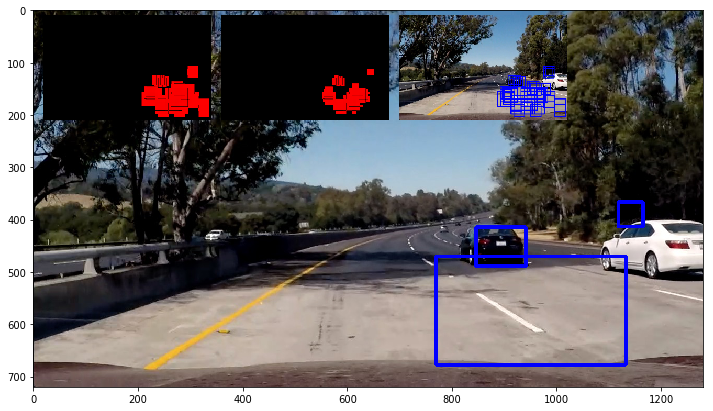

In [505]:
detector = VehicleDetectorWithMemory(classifier, normaliser, color_space="YCrCb")
detected_cars_img = detector.process_image(test_imgs[4])
plt.figure(figsize=(12,7))
#plt.imshow(detected_cars_img, cmap="hot")
plt.imshow(detected_cars_img)



Found 83 bounding boxes, 5 smooted ones and 5 labels
Distance= 0.0
**Found a match**
old centroid= (1181, 429)
new centroid= (1181, 429)
old bbox= [[1086  366]
 [1277  493]]
new bbox= [[1086  366]
 [1277  493]]
Distance= 318.8494942759044
Distance= 0.0
**Found a match**
old centroid= (884, 545)
new centroid= (884, 545)
old bbox= [[ 750  414]
 [1019  677]]
new bbox= [[ 750  414]
 [1019  677]]
Distance= 216.0925727552893
Distance= 119.5198728245642
Distance= 0.0
**Found a match**
old centroid= (967, 459)
new centroid= (967, 459)
old bbox= [[961 430]
 [973 489]]
new bbox= [[961 430]
 [973 489]]
Distance= 183.92661580097646
Distance= 136.95254652615992
Distance= 42.05948168962618
Distance= 0.0
**Found a match**
old centroid= (1004, 479)
new centroid= (1004, 479)
old bbox= [[ 978  470]
 [1030  489]]
new bbox= [[ 978  470]
 [1030  489]]
Distance= 268.8884527085535
Distance= 49.9799959983992
Distance= 77.82673062643708
Distance= 87.92041856133307
Distance= 0.0
**Found a match**
old centroid= 

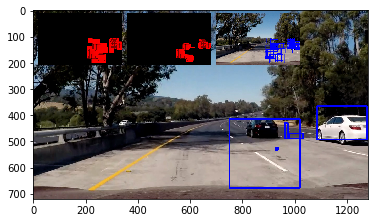

In [404]:
new_d_i = detector.process_image(test_imgs[4])
plt.imshow(new_d_i)

# Results

In [198]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [199]:
project_video_path = "project_video.mp4"
project_video_output_path = 'output_videos/project_video.mp4'

project_video_sample_path = 'project_video_sample.mp4'
project_video_sample_output_path = 'output_videos/project_video_sample.mp4'

## Sample Of Project Video

In [407]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(project_video_path, 7, 9, targetname=project_video_sample_path)


[MoviePy] Running:
>>> /Users/eddieforson/Library/Application Support/imageio/ffmpeg/ffmpeg.osx -y -i project_video.mp4 -ss 7.00 -t 2.00 -vcodec copy -acodec copy project_video_sample.mp4
... command successful.


In [506]:
detector = VehicleDetectorWithMemory(classifier, normaliser, color_space="YCrCb")

clip1 = VideoFileClip(project_video_sample_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_sample_output_path, audio=False)

Found 40 bounding boxes, 3 smooted ones and 3 labels
[((1134, 414), (1197, 477)), ((750, 508), (998, 691)), ((1082, 554), (1206, 656))]
[MoviePy] >>>> Building video output_videos/project_video_sample.mp4
[MoviePy] Writing video output_videos/project_video_sample.mp4



  2%|▏         | 1/50 [00:01<01:32,  1.89s/it]

Found 40 bounding boxes, 3 smooted ones and 3 labels
Distance= 0.0
**Found a match**
old centroid= (1165, 445)
new centroid= (1165, 445)
old bbox= [[1134  414]
 [1197  477]]
new bbox= [[1134  414]
 [1197  477]]
Distance= 329.23699670602025
Distance= 0.0
**Found a match**
old centroid= (874, 599)
new centroid= (874, 599)
old bbox= [[750 508]
 [998 691]]
new bbox= [[750 508]
 [998 691]]
Distance= 161.37224048763778
Distance= 270.06665843824555
Distance= 0.0
**Found a match**
old centroid= (1144, 605)
new centroid= (1144, 605)
old bbox= [[1082  554]
 [1206  656]]
new bbox= [[1082  554]
 [1206  656]]
[((1134, 414), (1197, 477)), ((750, 508), (998, 691)), ((1082, 554), (1206, 656))]



  4%|▍         | 2/50 [00:03<01:31,  1.91s/it]

Found 40 bounding boxes, 3 smooted ones and 3 labels
Distance= 0.0
**Found a match**
old centroid= (1165, 445)
new centroid= (1165, 445)
old bbox= [[1134  414]
 [1197  477]]
new bbox= [[1134  414]
 [1197  477]]
Distance= 329.23699670602025
Distance= 0.0
**Found a match**
old centroid= (874, 599)
new centroid= (874, 599)
old bbox= [[750 508]
 [998 691]]
new bbox= [[750 508]
 [998 691]]
Distance= 161.37224048763778
Distance= 270.06665843824555
Distance= 0.0
**Found a match**
old centroid= (1144, 605)
new centroid= (1144, 605)
old bbox= [[1082  554]
 [1206  656]]
new bbox= [[1082  554]
 [1206  656]]
[((1134, 414), (1197, 477)), ((750, 508), (998, 691)), ((1082, 554), (1206, 656))]



  6%|▌         | 3/50 [00:05<01:30,  1.92s/it]

Found 40 bounding boxes, 3 smooted ones and 3 labels
Distance= 0.0
**Found a match**
old centroid= (1165, 445)
new centroid= (1165, 445)
old bbox= [[1134  414]
 [1197  477]]
new bbox= [[1134  414]
 [1197  477]]
Distance= 329.23699670602025
Distance= 0.0
**Found a match**
old centroid= (874, 599)
new centroid= (874, 599)
old bbox= [[750 508]
 [998 691]]
new bbox= [[750 508]
 [998 691]]
Distance= 161.37224048763778
Distance= 270.06665843824555
Distance= 0.0
**Found a match**
old centroid= (1144, 605)
new centroid= (1144, 605)
old bbox= [[1082  554]
 [1206  656]]
new bbox= [[1082  554]
 [1206  656]]
[((1134, 414), (1197, 477)), ((750, 508), (998, 691)), ((1082, 554), (1206, 656))]



  8%|▊         | 4/50 [00:07<01:28,  1.92s/it]

Found 40 bounding boxes, 3 smooted ones and 3 labels
Distance= 0.0
**Found a match**
old centroid= (1165, 445)
new centroid= (1165, 445)
old bbox= [[1134  414]
 [1197  477]]
new bbox= [[1134  414]
 [1197  477]]
Distance= 329.23699670602025
Distance= 0.0
**Found a match**
old centroid= (874, 599)
new centroid= (874, 599)
old bbox= [[750 508]
 [998 691]]
new bbox= [[750 508]
 [998 691]]
Distance= 161.37224048763778
Distance= 270.06665843824555
Distance= 0.0
**Found a match**
old centroid= (1144, 605)
new centroid= (1144, 605)
old bbox= [[1082  554]
 [1206  656]]
new bbox= [[1082  554]
 [1206  656]]
[((1134, 414), (1197, 477)), ((750, 508), (998, 691)), ((1082, 554), (1206, 656))]



 10%|█         | 5/50 [00:09<01:26,  1.91s/it]

Found 40 bounding boxes, 3 smooted ones and 3 labels
Distance= 0.0
**Found a match**
old centroid= (1165, 445)
new centroid= (1165, 445)
old bbox= [[1134  414]
 [1197  477]]
new bbox= [[1134  414]
 [1197  477]]
Distance= 329.23699670602025
Distance= 0.0
**Found a match**
old centroid= (874, 599)
new centroid= (874, 599)
old bbox= [[750 508]
 [998 691]]
new bbox= [[750 508]
 [998 691]]
Distance= 161.37224048763778
Distance= 270.06665843824555
Distance= 0.0
**Found a match**
old centroid= (1144, 605)
new centroid= (1144, 605)
old bbox= [[1082  554]
 [1206  656]]
new bbox= [[1082  554]
 [1206  656]]
[((1134, 414), (1197, 477)), ((750, 508), (998, 691)), ((1082, 554), (1206, 656))]



 12%|█▏        | 6/50 [00:11<01:24,  1.91s/it]

Found 40 bounding boxes, 3 smooted ones and 3 labels
Distance= 0.0
**Found a match**
old centroid= (1165, 445)
new centroid= (1165, 445)
old bbox= [[1134  414]
 [1197  477]]
new bbox= [[1134  414]
 [1197  477]]
Distance= 329.23699670602025
Distance= 0.0
**Found a match**
old centroid= (874, 599)
new centroid= (874, 599)
old bbox= [[750 508]
 [998 691]]
new bbox= [[750 508]
 [998 691]]
Distance= 161.37224048763778
Distance= 270.06665843824555
Distance= 0.0
**Found a match**
old centroid= (1144, 605)
new centroid= (1144, 605)
old bbox= [[1082  554]
 [1206  656]]
new bbox= [[1082  554]
 [1206  656]]
[((1134, 414), (1197, 477)), ((750, 508), (998, 691)), ((1082, 554), (1206, 656))]



 14%|█▍        | 7/50 [00:13<01:22,  1.91s/it]

Found 57 bounding boxes, 6 smooted ones and 6 labels
Distance= 328.0
Distance= 158.38244852255568
Distance= 346.19214318063314
Distance= 8.0
**Found a match**
old centroid= (1173, 445)
new centroid= (1169, 445)
old bbox= [[1150  414]
 [1197  477]]
new bbox= [[1142  414]
 [1197  477]]
Distance= 51.478150704935004
Distance= 277.89386463180506
Distance= 141.41074923781431
Distance= 309.02588888311607
Distance= 21.213203435596427
Distance= 255.86324472264477
Distance= 123.96773773849388
Distance= 255.54842985234717
Distance= 45.31004303683677
Distance= 175.56765077883796
Distance= 164.97575579460153
Distance= 116.81181447096864
[((1142, 414), (1197, 477))]



 16%|█▌        | 8/50 [00:15<01:18,  1.88s/it]

Found 34 bounding boxes, 7 smooted ones and 7 labels
Distance= 4.0
**Found a match**
old centroid= (1173, 445)
new centroid= (1171, 445)
old bbox= [[1150  414]
 [1197  477]]
new bbox= [[1146  414]
 [1197  477]]
Distance= 333.77986757741996
Distance= 208.94257584322062
Distance= 157.62296786953354
Distance= 147.41099009232656
Distance= 186.00268815261785
Distance= 164.51443705644803
[((1146, 414), (1197, 477))]



 18%|█▊        | 9/50 [00:16<01:15,  1.85s/it]

Found 49 bounding boxes, 6 smooted ones and 6 labels
Distance= 6.0
**Found a match**
old centroid= (1165, 445)
new centroid= (1168, 445)
old bbox= [[1134  414]
 [1197  477]]
new bbox= [[1140  414]
 [1197  477]]
Distance= 344.6926166891307
Distance= 167.7647161950331
Distance= 123.40583454602137
Distance= 212.60761980700502
Distance= 183.56470248934025
[((1140, 414), (1197, 477))]



 20%|██        | 10/50 [00:18<01:14,  1.87s/it]

Found 48 bounding boxes, 5 smooted ones and 5 labels
Distance= 2.0
**Found a match**
old centroid= (1170, 445)
new centroid= (1169, 445)
old bbox= [[1134  414]
 [1206  477]]
new bbox= [[1137  414]
 [1201  477]]
Distance= 273.76632371422164
Distance= 53.33854141237835
Distance= 98.15294188153507
Distance= 194.94101672044292
[((1137, 414), (1201, 477))]



 22%|██▏       | 11/50 [00:20<01:12,  1.85s/it]

Found 42 bounding boxes, 3 smooted ones and 3 labels
Distance= 8.94427190999916
**Found a match**
old centroid= (1165, 453)
new centroid= (1167, 449)
old bbox= [[1134  430]
 [1197  477]]
new bbox= [[1135  422]
 [1199  477]]
Distance= 247.00202428320299
Distance= 93.55746896961247
[((1135, 422), (1199, 477))]



 24%|██▍       | 12/50 [00:22<01:11,  1.88s/it]

Found 48 bounding boxes, 2 smooted ones and 2 labels
Distance= 271.6799587750263
Distance= 161.04657711357916
[]



 26%|██▌       | 13/50 [00:24<01:09,  1.88s/it]

Found 33 bounding boxes, 3 smooted ones and 3 labels
[]



 28%|██▊       | 14/50 [00:26<01:07,  1.88s/it]

Found 43 bounding boxes, 1 smooted ones and 1 labels
[]



 30%|███       | 15/50 [00:28<01:06,  1.89s/it]

Found 27 bounding boxes, 3 smooted ones and 3 labels
[]



 32%|███▏      | 16/50 [00:30<01:03,  1.88s/it]

Found 43 bounding boxes, 3 smooted ones and 3 labels
[]



 34%|███▍      | 17/50 [00:32<01:02,  1.89s/it]

Found 34 bounding boxes, 4 smooted ones and 4 labels
[]



 36%|███▌      | 18/50 [00:33<00:59,  1.86s/it]

Found 45 bounding boxes, 4 smooted ones and 4 labels
[]



 38%|███▊      | 19/50 [00:35<00:57,  1.87s/it]

Found 36 bounding boxes, 2 smooted ones and 2 labels
[]



 40%|████      | 20/50 [00:37<00:55,  1.86s/it]

Found 39 bounding boxes, 2 smooted ones and 2 labels
[]



 42%|████▏     | 21/50 [00:39<00:52,  1.83s/it]

Found 33 bounding boxes, 3 smooted ones and 3 labels
[]



 44%|████▍     | 22/50 [00:41<00:51,  1.84s/it]

Found 36 bounding boxes, 3 smooted ones and 3 labels
[]



 46%|████▌     | 23/50 [00:43<00:49,  1.83s/it]

Found 53 bounding boxes, 3 smooted ones and 3 labels
[]



 48%|████▊     | 24/50 [00:44<00:46,  1.80s/it]

Found 37 bounding boxes, 3 smooted ones and 3 labels
[]



 50%|█████     | 25/50 [00:46<00:44,  1.80s/it]

Found 40 bounding boxes, 1 smooted ones and 1 labels
[]



 52%|█████▏    | 26/50 [00:48<00:43,  1.82s/it]

Found 40 bounding boxes, 3 smooted ones and 3 labels
[]



 54%|█████▍    | 27/50 [00:50<00:42,  1.84s/it]

Found 46 bounding boxes, 4 smooted ones and 4 labels
[]



 56%|█████▌    | 28/50 [00:52<00:40,  1.83s/it]

Found 31 bounding boxes, 2 smooted ones and 2 labels
[]



 58%|█████▊    | 29/50 [00:53<00:37,  1.80s/it]

Found 24 bounding boxes, 4 smooted ones and 4 labels
[]



 60%|██████    | 30/50 [00:55<00:35,  1.79s/it]

Found 33 bounding boxes, 3 smooted ones and 3 labels
[]



 62%|██████▏   | 31/50 [00:57<00:35,  1.84s/it]

Found 31 bounding boxes, 6 smooted ones and 6 labels
[]



 64%|██████▍   | 32/50 [00:59<00:33,  1.86s/it]

Found 48 bounding boxes, 2 smooted ones and 2 labels
[]



 66%|██████▌   | 33/50 [01:01<00:31,  1.86s/it]

Found 30 bounding boxes, 3 smooted ones and 3 labels
[]



 68%|██████▊   | 34/50 [01:03<00:30,  1.88s/it]

Found 43 bounding boxes, 4 smooted ones and 4 labels
[]



 70%|███████   | 35/50 [01:05<00:28,  1.87s/it]

Found 40 bounding boxes, 3 smooted ones and 3 labels
[]



 72%|███████▏  | 36/50 [01:06<00:25,  1.84s/it]

Found 52 bounding boxes, 2 smooted ones and 2 labels
[]



 74%|███████▍  | 37/50 [01:08<00:24,  1.86s/it]

Found 59 bounding boxes, 2 smooted ones and 2 labels
[]



 76%|███████▌  | 38/50 [01:10<00:21,  1.82s/it]

Found 49 bounding boxes, 5 smooted ones and 5 labels
[]



 78%|███████▊  | 39/50 [01:12<00:20,  1.83s/it]

Found 46 bounding boxes, 1 smooted ones and 1 labels
[]



 80%|████████  | 40/50 [01:14<00:18,  1.83s/it]

Found 38 bounding boxes, 2 smooted ones and 2 labels
[]



 82%|████████▏ | 41/50 [01:16<00:16,  1.85s/it]

Found 31 bounding boxes, 3 smooted ones and 3 labels
[]



 84%|████████▍ | 42/50 [01:18<00:15,  1.88s/it]

Found 41 bounding boxes, 5 smooted ones and 5 labels
[]



 86%|████████▌ | 43/50 [01:20<00:13,  1.90s/it]

Found 30 bounding boxes, 2 smooted ones and 2 labels
[]



 88%|████████▊ | 44/50 [01:21<00:11,  1.91s/it]

Found 36 bounding boxes, 3 smooted ones and 3 labels
[]



 90%|█████████ | 45/50 [01:23<00:09,  1.90s/it]

Found 46 bounding boxes, 2 smooted ones and 2 labels
[]



 92%|█████████▏| 46/50 [01:25<00:07,  1.92s/it]

Found 62 bounding boxes, 4 smooted ones and 4 labels
[]



 94%|█████████▍| 47/50 [01:27<00:05,  1.93s/it]

Found 48 bounding boxes, 2 smooted ones and 2 labels
[]



 96%|█████████▌| 48/50 [01:29<00:03,  1.93s/it]

Found 52 bounding boxes, 3 smooted ones and 3 labels
[]



 98%|█████████▊| 49/50 [01:31<00:01,  1.92s/it]

Found 56 bounding boxes, 1 smooted ones and 1 labels
[]



100%|██████████| 50/50 [01:33<00:00,  1.92s/it]

Found 59 bounding boxes, 2 smooted ones and 2 labels
[]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_sample.mp4 

CPU times: user 1min 22s, sys: 4.6 s, total: 1min 27s
Wall time: 1min 35s


In [507]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_sample_output_path))